In [17]:

import pandas as pd
import numpy as np
import os, sys
import plotly.express as px
import h5py
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import stats
# pvlib imports
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

import zipfile
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame


In [2]:

# Set working directory
os.chdir(r"..") # should be the git repo root directory
print("Current working directory: " + os.getcwd())
repo_name = 'net-load-forecasting'
assert os.getcwd()[-len(repo_name):] == "net-load-forecasting", "Working directory is not the git repo root directory"

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\net-load-forecasting


In [3]:
save_path = os.path.join(os.getcwd(),'data','clean_data')
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print("Created directory: " + save_path)

In [4]:
# Import custom functions
from utils.utils import *

# Data Imports & Cleaning for the Project 

## &#x2460; Energy Community Load Data - Germany

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.5642902.svg)](https://doi.org/10.5281/zenodo.5642902) 

Note: Due to their size we have not included the datasets in the repo, but the above link will allow you to download them, np.

We have downloaded the load data for [2018,2019,2020] in [1 minute*, 15 minutes] resolution:

* 2018_data_1min.zip, 2019_data_1min.zip, 2020_data_1min.zip
* 2018_data_15min.zip, 2019_data_15min.zip, 2020_data_15min.zip,

The goal here is to import them, select the useful data, impute missing data where plausible and aggregate to one community for both temporal resolutions

In [8]:
#h5py extraction
resolutions = [
                '1min',
                '15min']

df_load_per_resolution = {}
store = pd.HDFStore(os.path.join(save_path, "df_load_per_resolution.h5"))

for resolution in resolutions:

    dfs_load = []
    for year in [2018,2019, 2020]:

        with zipfile.ZipFile(f"data/raw_data/load/{year}_data_{resolution}.zip") as zip_file:

            hdf5_file = zip_file.open(f"{year}_data_{resolution}.hdf5")

            f = h5py.File(hdf5_file)
            group_no_pv = f["NO_PV"] #Only regard those profiles that are not mixed with PV generation
            dfs = {}
            community_members = [ # these are the households with reliable data for the considered duration
                        'SFH3', 'SFH4', 'SFH5', 'SFH9', 'SFH10',
                        'SFH12', 'SFH16','SFH18','SFH19', 'SFH21',
                        'SFH22', 'SFH23', 'SFH27', 'SFH28', 'SFH29',
                        'SFH30', 'SFH31','SFH32', 'SFH36', 'SFH38'
                        ]
            
            for member in community_members:
                table = f["NO_PV"][member]["HOUSEHOLD"]["table"][:]
                df = pd.DataFrame(table).dropna().set_index("index")[["P_TOT"]]
                df.index = pd.to_datetime(df.index, unit = "s")
                dfs[member] = df
                break

            df_load = pd.concat(dfs, axis=1).sum(axis=1).to_frame('total_load')
            dfs_load.append(df_load)

    df_load_total = pd.concat(dfs_load, axis=0)
    df_load_per_resolution[resolution] = df_load_total
    store.put(f'{resolution}/data', df_load_total, format='table')
store.close()   

c:\Users\nik\miniconda3\envs\netload\Lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1min'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [9]:
df_load_per_resolution['1min']

,total_load
index,
2018-05-02 14:41:00,0.000000
2018-05-02 14:42:00,0.000000
2018-05-02 14:43:00,0.000000
2018-05-02 14:44:00,0.000000
2018-05-02 14:45:00,0.000000
...,...
2020-12-31 23:55:00,232.789993
2020-12-31 23:56:00,232.789993
2020-12-31 23:57:00,232.789993


In [10]:
pd.read_hdf(os.path.join(save_path, "df_load_per_resolution.h5"), key='1min/data')

,total_load
index,
2018-05-02 14:41:00,0.000000
2018-05-02 14:42:00,0.000000
2018-05-02 14:43:00,0.000000
2018-05-02 14:44:00,0.000000
2018-05-02 14:45:00,0.000000
...,...
2020-12-31 23:55:00,232.789993
2020-12-31 23:56:00,232.789993
2020-12-31 23:57:00,232.789993


## &#x2461; PV Power Data - Netherlands

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6906504.svg)](https://doi.org/10.5281/zenodo.6906504)

We have downloaded the 'filtered_pv_power_measurements_ac.csv' file

Note: While meta data is available for download, exact locations of individual PV systems are not included. Since one of the key research questions of this project is to investigate the impact of using exact locations in modeling, we recieved special permission to use the longitude and latitude of PV systems. Unfortunately we cannot share these here. The rest of the code is provided to calculate the locations from the bounding box locations provided in the open-source 'metadata.csv', however. 

Note: Due to their size we have not included the datasets in the repo, but the above link will allow you to download them, and execute the notebook as long as the paths are adjusted.

In [11]:
df_pv = pd.read_csv(os.path.join(os.getcwd(), 'data', 'raw_data', 'pv', 'filtered_pv_power_measurements_ac.csv'), index_col=0, parse_dates=True)

### Meta Data

In [12]:
df_meta = pd.read_csv(os.path.join(os.getcwd(), 'data', 'raw_data', 'pv', 'metadata.csv'), sep=';')

df_meta['latitude'] = (df_meta['north'] + df_meta['south']) / 2
df_meta['longitude'] = (df_meta['east'] + df_meta['west']) / 2

df_meta = df_meta[['ID', 'latitude', 'longitude', 'tilt', 'azimuth', 'estimated_dc_capacity', 'estimated_ac_capacity']]

df_meta


,ID,latitude,longitude,tilt,azimuth,estimated_dc_capacity,estimated_ac_capacity
0,ID001,52.034861,5.174167,42.0,150,2711,2670
1,ID002,51.970139,5.329167,30.0,170,1902,2000
2,ID003,52.108750,5.125278,40.0,203,2503,2250
3,ID004,52.095694,5.119722,35.0,190,2087,2030
4,ID005,52.074583,5.128611,15.0,180,2413,2500
...,...,...,...,...,...,...,...
170,ID171,52.083750,5.110833,43.0,148,1499,1300
171,ID172,51.965556,5.155556,45.0,107,4919,5000
172,ID173,52.269167,5.173889,15.0,235,1388,1750
173,ID174,52.092361,5.090556,45.0,273,1765,2000


<Figure size 1000x1000 with 0 Axes>

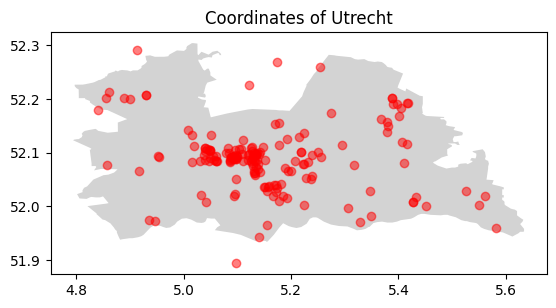

In [15]:
# Lets visualize the coordinates of the PV systems on a map

# Read the shapefile of the Netherlands
netherlands = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")

# Select the city of Utrecht
utrecht = netherlands.iloc[[10]]

# Create a dataframe of the coordinates
df_coords = df_meta[['ID','latitude','longitude']].copy()
df_coords.set_index('ID', inplace=True)

# Create a list of points from the coordinates
geometry = [Point(xy) for xy in zip(df_coords['longitude'], df_coords['latitude'])]

# Create a GeoDataFrame from the coordinates
gdf = GeoDataFrame(df_coords, geometry=geometry)

# Plot the map of the Netherlands
plt.figure(figsize=(10, 10))
ax = utrecht.plot(color='lightgray')

# Plot the coordinates on the map
gdf.plot(ax=ax, color='red', marker='o', alpha=0.5)

# Add a title to the plot
plt.title('Coordinates of Utrecht')
# Show the plot
plt.show()

In [ ]:
# Now lets 

### Power Data

In [24]:
df_pv = pd.read_csv(os.path.join(os.getcwd(), 'data', 'raw_data', 'pv', 'filtered_pv_power_measurements_ac.csv'), index_col=0, parse_dates=True)

df_pv.head()

## &#x2462; Irradiance Data - Netherlands



In [23]:
lat_avg = df_meta['latitude'].mean()
lng_avg = df_meta['longitude'].mean()
start_date = df_pv_filtered.index[0]
end_date = df_pv_filtered.index[-1]
variables =  ['temperature_2m', 'direct_radiation', 'direct_normal_irradiance']


df_weather = get_weather_data(lat_avg, lng_avg, start_date, end_date, variables)

df_weather

,time,temperature_2m
0,2018-01-01T00:00,7.7
1,2018-01-01T01:00,7.2
2,2018-01-01T02:00,7.0
3,2018-01-01T03:00,7.2
4,2018-01-01T04:00,6.8
...,...,...
26299,2020-12-31T19:00,0.8
26300,2020-12-31T20:00,0.5
26301,2020-12-31T21:00,0.4
26302,2020-12-31T22:00,0.4


## &#x2463; Imbalance Price Data - Netherlands



# Data Merging & Saving 